In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

#### 7 different classes of skin cancer:
1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma

## Importing Essential Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

2024-02-17 10:36:31.309743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 10:36:31.309878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 10:36:31.485457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
base_dir = '/kaggle/input/skin-cancer-mnist-ham10000/'

In [6]:
image_paths_part1 = glob(os.path.join(base_dir, 'HAM10000_images_part_1', '*.jpg'))
image_paths_part2 = glob(os.path.join(base_dir, 'HAM10000_images_part_2', '*.jpg'))

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths_part1 + image_paths_part2}

## Dictionary of images and labels

In [8]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

## Reading and Processing Data

In [9]:
skin_df = pd.read_csv(os.path.join(base_dir,'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [10]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

## Data Cleaning

In [11]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [12]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

/tmp/ipykernel_34/3479505362.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


In [13]:
skin_df.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object

## Exploratory data analysis (EDA)

<Axes: xlabel='cell_type'>

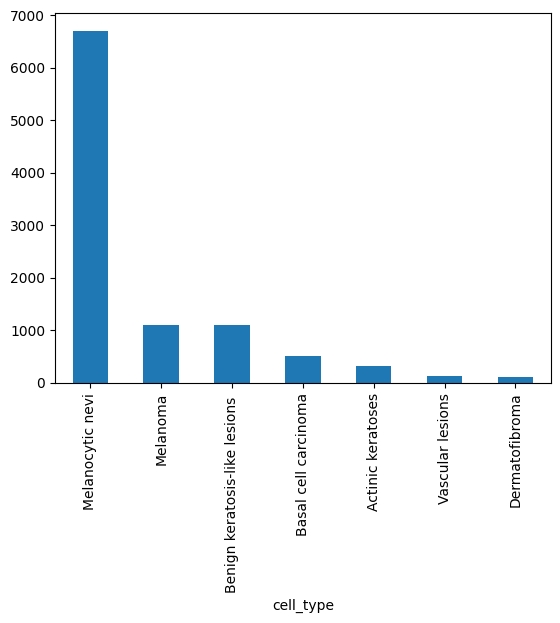

In [14]:
skin_df['cell_type'].value_counts().plot(kind='bar')

<Axes: xlabel='dx_type'>

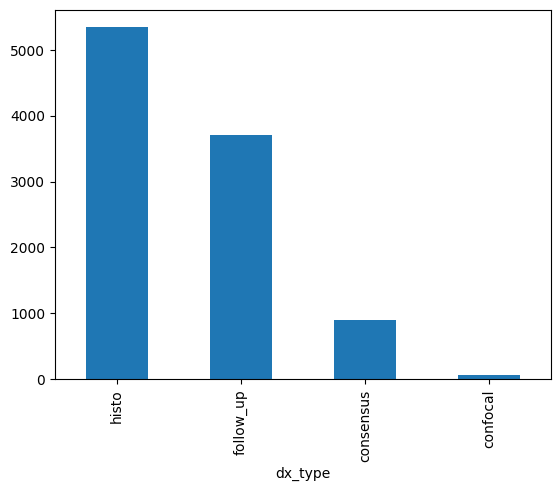

In [15]:
skin_df['dx_type'].value_counts().plot.bar()

**1. Histopathology(Histo):** Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists.
<br>
**2. Confocal:** Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after manual histogram changes.<br>
**3. Follow-up:** If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.<br>
**4. Consensus:** For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

<Axes: xlabel='localization'>

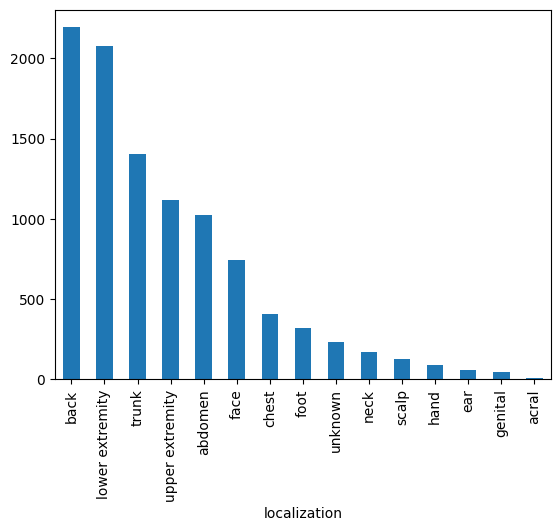

In [16]:
skin_df['localization'].value_counts().plot.bar()

<Axes: >

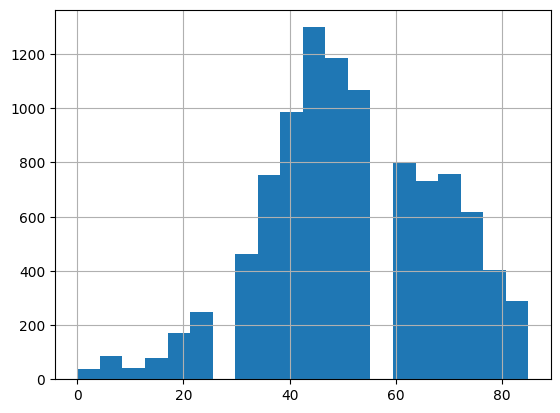

In [17]:
skin_df['age'].hist(bins=20)

In [18]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

<Axes: xlabel='sex'>

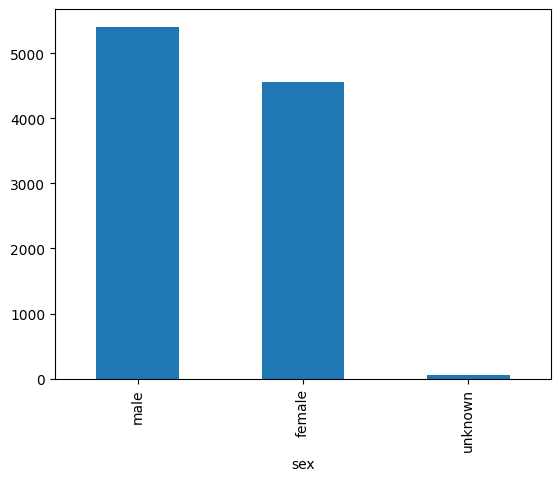

In [19]:
skin_df['sex'].value_counts().plot.bar()

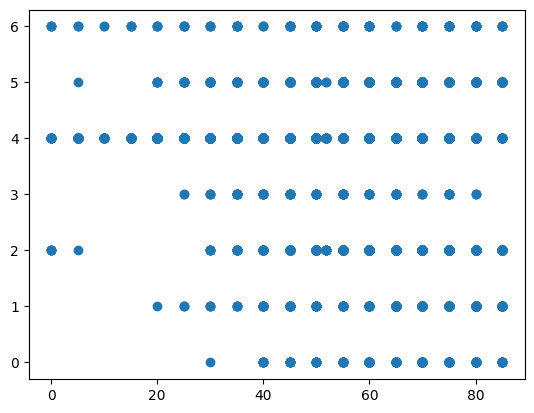

In [20]:
plt.scatter(skin_df['age'],skin_df['cell_type_idx'])

## Loading & Resizing of images

In [21]:
skin_df['image'] = skin_df['path'].map(lambda x:np.asarray(Image.open(x).resize((100,75))))

In [22]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                        cell_type  cell_type_idx  \
0  Benign keratosis-like lesions               2   
1  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
3  Benign keratosis-like lesions               2   
4  Benign keratosis-like lesions               2   

                                               image  
0  [[[190, 153, 194], [192, 154, 196], [191, 153,...  
1  [[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...  
2  [[[185, 127, 137], [189, 133, 147], [194, 136,...  
3  [[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...  
4  [[[134, 90, 113], [147, 102, 125], [159, 115, ...

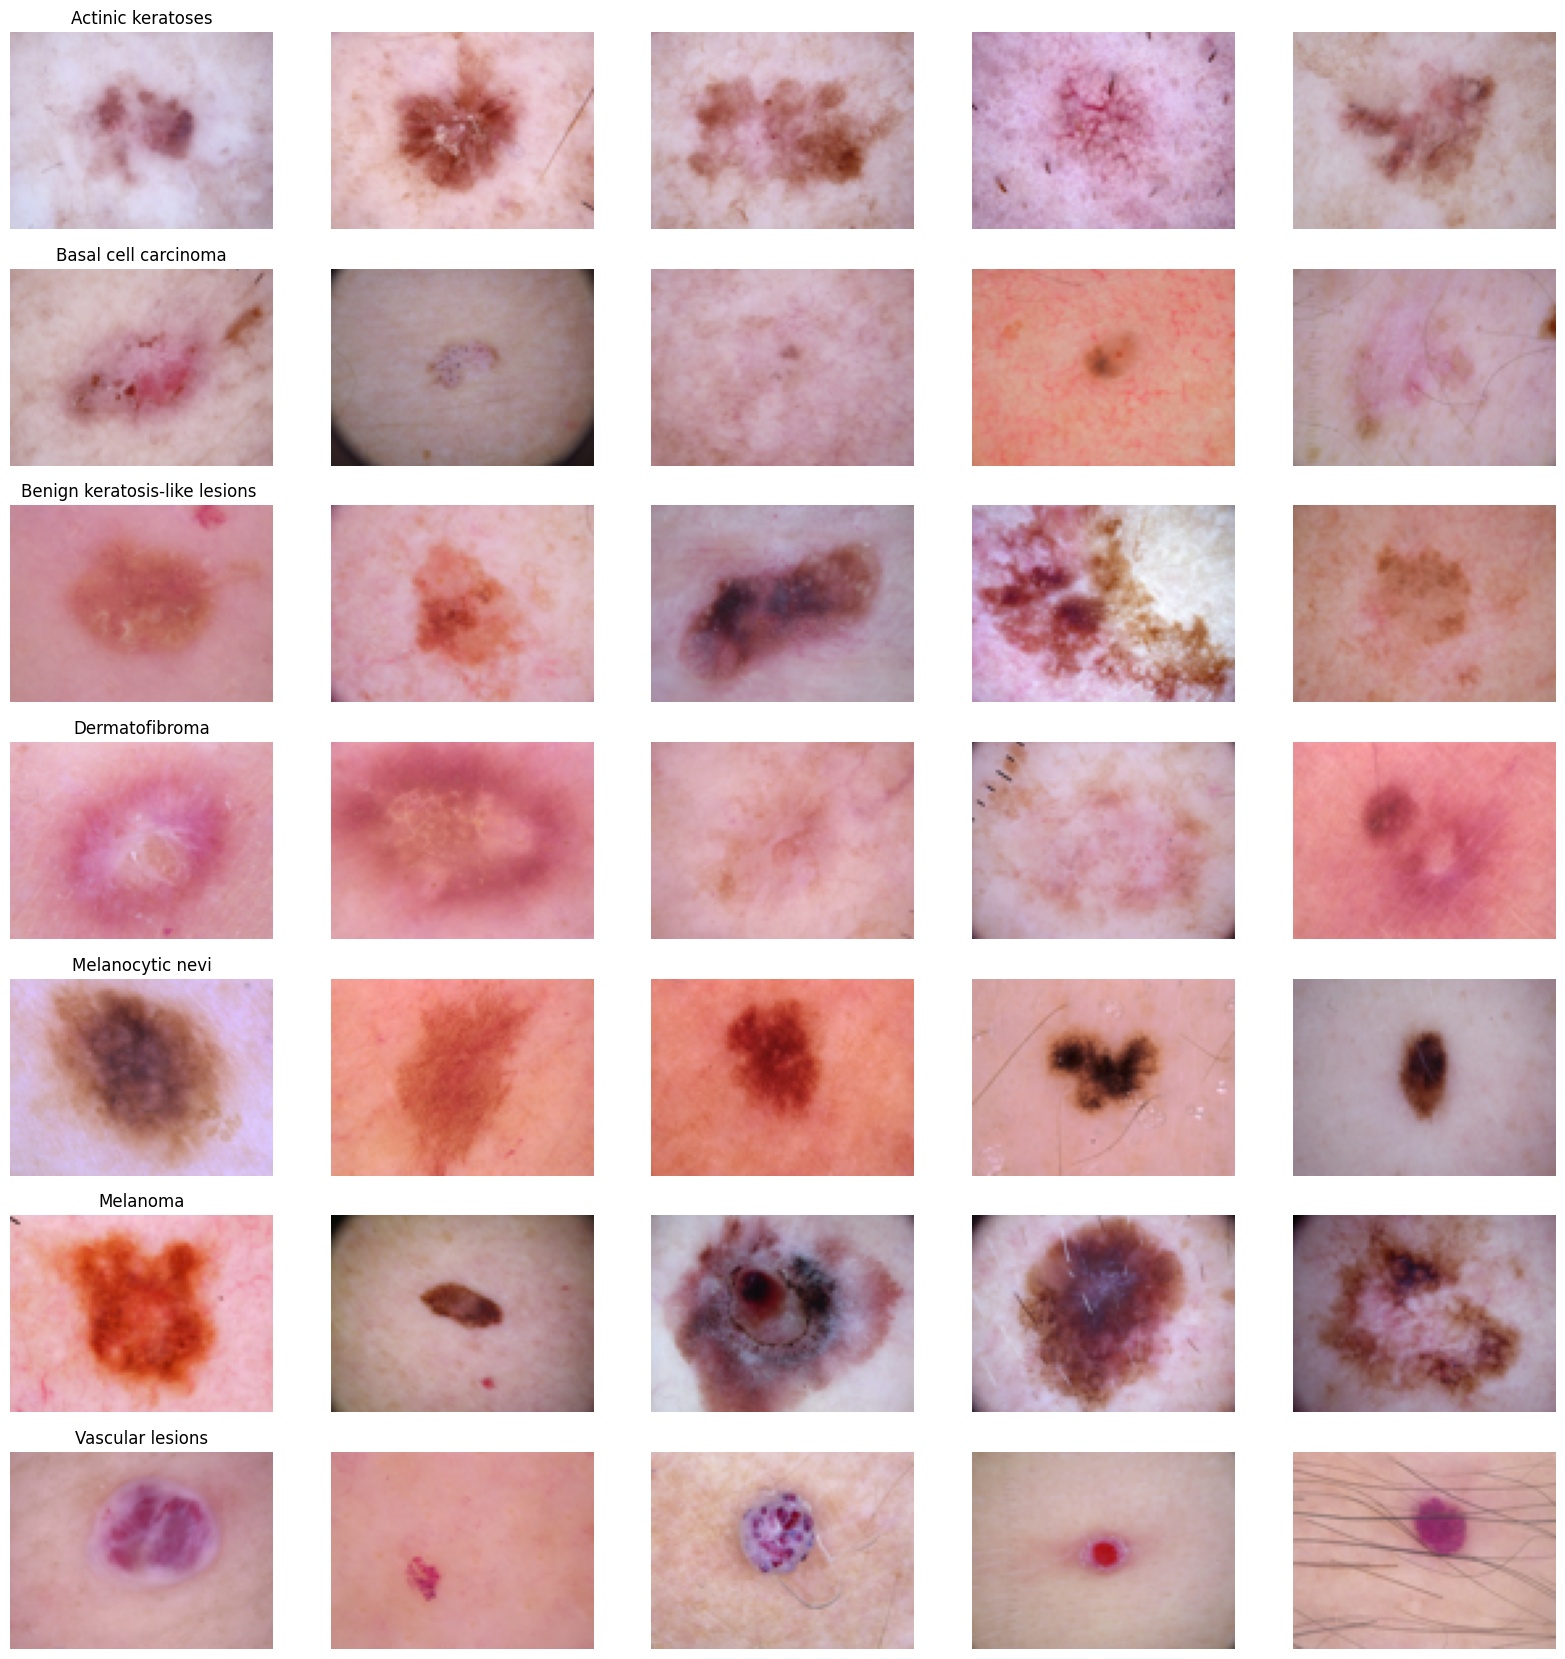

In [23]:
fig, axes = plt.subplots(7,5,figsize=(20,21))
for ax,(t_name,t_rows) in zip(axes,skin_df.sort_values(['cell_type']).groupby('cell_type')):
    ax[0].set_title(t_name)
    for cax, (_,crow) in zip(ax,t_rows.sample(5,random_state=43).iterrows()):
        cax.imshow(crow['image'])
        cax.axis('off')
        

In [24]:
X = skin_df.drop(columns=['cell_type_idx'],axis=1)
y = skin_df['cell_type_idx']

## Train Test Split

In [59]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=43)

## Normalization

In [60]:
X_train.shape

(8012, 10)

In [61]:
X_test.shape 

(2003, 10)

In [37]:
X_train = np.asarray(X_train['image']).tolist()
X_test = np.asarray(X_test['image']).tolist()

X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

X_test_mean = np.mean(X_test)
X_test_std = np.std(X_test)

X_train = (X_train - X_train_mean)/X_train_std
X_test = (X_test - X_test_mean)/X_test_std

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Label Encoding

In [27]:
y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)

## Train validation split

In [28]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2)

In [29]:
X_train = X_train.reshape(X_train.shape[0], * (_))
X_test = X_test.reshape(X_test.shape[0], * (75,100,3))
X_validate = X_validate.reshape(X_validate.shape[0], * (75,100,3))

## Model Building

In [30]:
input_shape = (75,100,3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='Same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='Same'))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='Same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 50, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

## Setting Optimizer & Annealing

In [31]:
optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,amsgrad=False)

In [32]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'],run_eagerly=True)

In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

## Data Augmentation

In [34]:
datagen = ImageDataGenerator(featurewise_center=False,samplewise_center=False,featurewise_std_normalization=False,samplewise_std_normalization=False,zca_whitening=False,rotation_range=10,zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=False,vertical_flip=False)
datagen.fit(X_train)

In [35]:
X_train.shape

(7210, 75, 100, 3)

In [36]:

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=10),
    epochs=50,
    validation_data=(X_validate, y_validate),
    verbose=1,
    steps_per_epoch=X_train.shape[0] // 10,  
    callbacks=[learning_rate_reduction],
)

Epoch 1/50


I0000 00:00:1708166516.344254      34 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


721/721 [==============================] - 44s 53ms/step - loss: 1.0159 - accuracy: 0.6666 - val_loss: 0.9035 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 2/50
721/721 [==============================] - 38s 52ms/step - loss: 0.9296 - accuracy: 0.6712 - val_loss: 0.8682 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 3/50
721/721 [==============================] - 38s 53ms/step - loss: 0.8929 - accuracy: 0.6714 - val_loss: 0.8101 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 4/50
721/721 [==============================] - 38s 52ms/step - loss: 0.8581 - accuracy: 0.6818 - val_loss: 0.8216 - val_accuracy: 0.6733 - lr: 0.0010
Epoch 5/50
721/721 [==============================] - 39s 54ms/step - loss: 0.8442 - accuracy: 0.6871 - val_loss: 0.7814 - val_accuracy: 0.6945 - lr: 0.0010
Epoch 6/50
721/721 [==============================] - 38s 53ms/step - loss: 0.8127 - accuracy: 0.6965 - val_loss: 0.7469 - val_accuracy: 0.7257 - lr: 0.0010
Epoch 7/50
721/721 [==============================] - 37s 51ms/step -

In [39]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(X_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

26/26 [==============================] - 1s 19ms/step - loss: 0.6962 - accuracy: 0.7581
Validation: accuracy = 0.758105  ;  loss_v = 0.696198
Test: accuracy = 0.755866  ;  loss = 0.676544


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Fitting the model

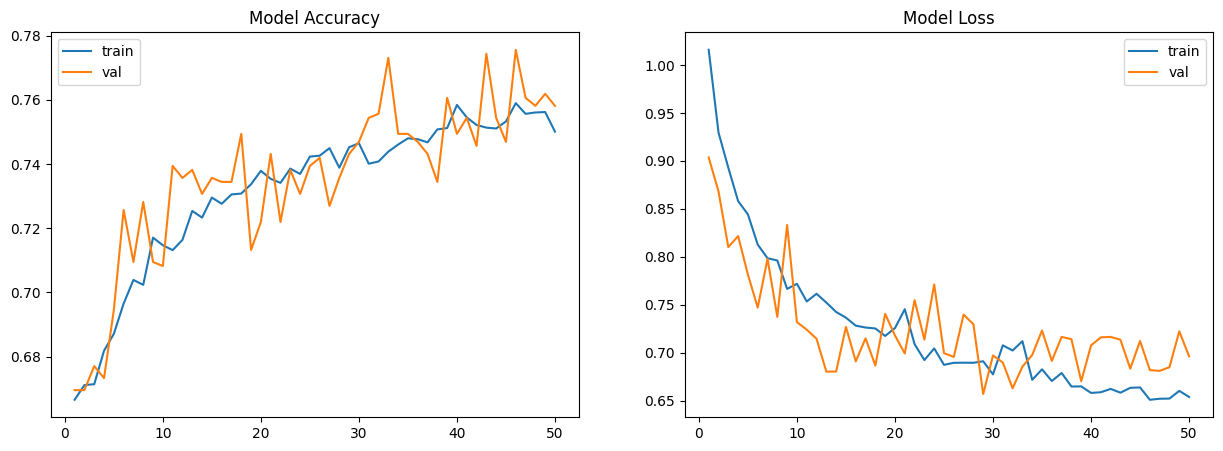

In [45]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
axes[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].legend(['train','val'],loc='best')

axes[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
axes[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].legend(['train','val'],loc='best')


In [55]:
def plot_confusion_matrix(cm,classes,normalize=False,cmap=plt.cm.Purples):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.colorbar()
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

26/26 [==============================] - 0s 10ms/step


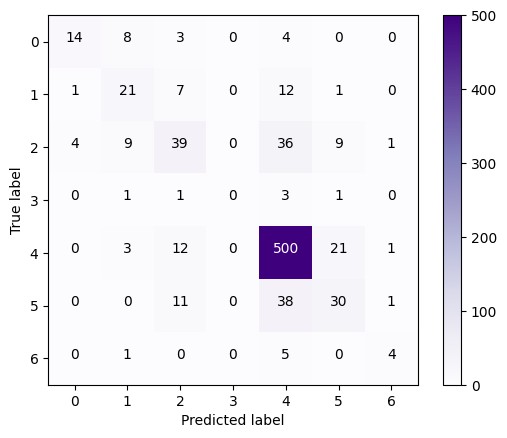

In [56]:
y_pred = model.predict(X_validate)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_validate,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

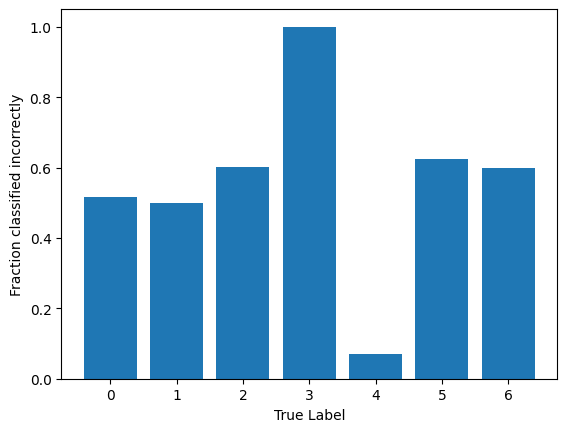

In [57]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')